# Example of usage

In [1]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

Install requierements

In [10]:
#!pip install xarray numpy ffmpeg scikit-image

Load required libraries

In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
from xarrayvideo import xarray2video, video2xarray

Set up some variables and load an example minicube

In [3]:
array_id= '-111.49_38.60'
input_path= '/scratch/users/deepextremes/deepextremes-minicubes/full/1.2.2/mc_-111.49_38.60_1.2.2_20230702_0.zarr'
output_path= './out'

minicube= xr.open_dataset(input_path, engine='zarr')
minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
minicube= minicube.drop_vars('B07') #We drop a variable for now

In [4]:
minicube

<xarray.Dataset>
Dimensions:       (time: 495, y: 128, x: 128, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 2016-01-03T12:00:00 ... 2022-10-08T12...
  * x             (x) float64 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 9.785e+05 9.788e+05 ... 9.806e+05 9.809e+05
  * y             (y) float64 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 4.288e+06 4.287e+06 ... 4.286e+06 4.285e+06
Data variables: (12/37)
    B02           (time, y, x) float32 ...
    B03           (time, y, x) float32 ...
    B04           (time, y, x) float32 ...
    B05           (time, y, x) float32 ...
    B06           (time, y, x) float32 ...
    B8A           (time, y, x) float32 ...
    ...            ...
    t2m_max       (time) float32 ...
    t2m_mean      (time) float32 ...
    t2m_min       (time) float32 ...
    tp_max        (time) float32 ...
    tp_mean       (time) float32 ...
    tp_min        (time) float32 ...
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Define conversion rules for the different bands. The syntax is:
```
'video_name': ( 
    var or (var1, var2, var3), #Variables present in the xarray
    (t_coord_name, x_coord_name, y_coord_name), #Names of the coordinates in order (t, x, y)
    'lossy' or 'lossless' #compression (e.g. lossless for uint8 masks)
    ),
...
```

In [5]:
#Define conversion rules for the different bands
conversion_rules= {
    # 'r': ( 'B04', ('time','x','y'), 'lossy'), #1 channel + lossy not working
    # 'ir4': ( ('B8A','B07','B06','B05'), ('time','x','y'), 'lossy'), #4 channels not working
    'rgb': ( ('B04','B03','B02'), ('time','x','y'), 'lossy'),
    'ir3': ( ('B8A','B06','B05'), ('time','x','y'), 'lossy'),
    'cm': ( 'cloudmask_en', ('time','x','y'), 'lossless'),
    'scl': ( 'SCL', ('time','x','y'), 'lossless'),
    }

Compress and write new file

In [19]:
#Define the output video encoding parameters
#Lossless
lossless_params= {'vcodec':'ffv1'}

#Lossy
lossy_params = {
    'c:v': 'libx264',  #libx264 always seems better for rgb[libx264, libx265, vp9, ffv1]
    'preset': 'slow',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': 14, #11 for higher quality and size
    }

#Run with compute_stats (takes 
minicube.to_zarr(Path(output_path) / f'{array_id}.zarr')
arr_dict= xarray2video(minicube, array_id, conversion_rules, value_range=(0.,1.), compute_stats=True,
                       lossy_params=lossy_params, lossless_params=lossless_params, fmt='mkv',
                       output_path=output_path, use_ssim=False,
                       loglevel='quiet', #verbose, quiet
                       )  

rgb: 23.20Mb -> 0.75Mb (3.22% of original size) in 1.11s
 - params={'c:v': 'libx264', 'preset': 'slow', 'crf': 14, 'pix_fmt': 'rgb24', 'r': 30}
 - MSE_sat 0.000087 (input saturated to [(0.0, 1.0)])
ir3: 23.20Mb -> 0.72Mb (3.09% of original size) in 0.98s
 - params={'c:v': 'libx264', 'preset': 'slow', 'crf': 14, 'pix_fmt': 'rgb24', 'r': 30}
 - MSE_sat 0.000101 (input saturated to [(0.0, 1.0)])
cm: 7.73Mb -> 0.08Mb (0.98% of original size) in 0.09s
 - params={'vcodec': 'ffv1', 'pix_fmt': 'gray', 'r': 30}
 - acc 1.00
scl: 7.73Mb -> 0.29Mb (3.70% of original size) in 0.10s
 - params={'vcodec': 'ffv1', 'pix_fmt': 'gray', 'r': 30}
 - acc 1.00


Compute total size, and observe a signficant compression rate (~20x)

In [20]:
original_path= str(Path(output_path) / f'{array_id}.zarr')
!du -h {original_path} -d0

56M	out/-111.49_38.60.zarr


In [21]:
new_path= str(Path(output_path) / f'{array_id}')
!du -h {new_path} -d0

2,4M	out/-111.49_38.60


Read again the written file, and check that everything has persisted

In [31]:
minicube_new= video2xarray(output_path, array_id, fmt='mkv') 
minicube_new

<xarray.Dataset>
Dimensions:       (y: 128, x: 128, time: 495, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 2016-01-03T12:00:00 ... 2022-10-08T12...
  * x             (x) float64 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 9.785e+05 9.788e+05 ... 9.806e+05 9.809e+05
  * y             (y) float64 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 4.288e+06 4.287e+06 ... 4.286e+06 4.285e+06
Data variables: (12/37)
    cop_dem       (y, x) float32 ...
    crs_300       int64 ...
    e_max         (time) float32 ...
    e_mean        (time) float32 ...
    e_min         (time) float32 ...
    event_labels  (event_time) uint16 ...
    ...            ...
    B02           (time, y, x) float32 0.0 0.0 0.0 ... 0.0549 0.05882 0.05882
    B8A           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1725 0.1647 0.1608
    B06           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1412 0.1333 0.1294
    B05           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1137 0.1098 0.1059
    cloudmask_en  (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SCL           (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5 5
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Visualize results

In [43]:
#!pip install git+https://github.com/OscarPellicer/txyvis.git

In [45]:
from txyvis import plot_maps
# sys.path.append('/home/oscar/txyXAI'); from lib.visualization import plot_maps
import cv2

In [55]:
txy_mask= minicube['cloudmask_en'].values[:,None] > 0 #t,x,y -> t,1,x,y
t= minicube.time.values
xlabels= list(map(lambda i_d: f'{i_d[0]}\n{np.datetime_as_string((i_d[1]), unit="D")}', enumerate(t)))
select=slice(None,None,1)

#RGB orig
txy_real_original= np.transpose(arr_dict['rgb'][1], (0,3,1,2)) #t,x,y,3 -> t,3,x,y
plot_idx= [[0,1,2]]
img_orig= plot_maps(
        images=[txy_real_original[select, idx] for idx in plot_idx], 
        masks=[txy_mask[select]]*len(plot_idx), #Repat mask len(images) times
        cmaps=[None], 
        centers=[False],
        limits= [(0,0.3)],
        ylabels=['RGB'], 
        xlabels=xlabels[select],
        mask_kwargs=dict(colors= {0:None, 1:'r'}), classes= {1:'Invalid'},
        title='Original', 
        backend='numpy',
        numpy_backend_kwargs={'size':13, 'color':'black', 'xstep':4,
                              'labels':'grid', 'font':'OpenSans_Condensed-Regular.ttf'},
        plot_mask_channel=None, matplotlib_backend_kwargs={'text_size':20},
        figsize=(27.5,10),
        stack_every=73, #Stack every year (approx.) 73*5=365
                    )
cv2.imwrite(f'img_orig.jpg', img_orig[...,[2,1,0]])

#RGB compressed
txy_real_compressed= np.transpose(arr_dict['rgb'][0], (0,3,1,2)) #t,x,y,3 -> 3,t,x,y
plot_idx= [[0,1,2]]
img_orig= plot_maps(
        images=[txy_real_compressed[select, idx] for idx in plot_idx], 
        masks=[txy_mask[select]]*len(plot_idx), #Repat mask len(images) times
        cmaps=[None], 
        centers=[False],
        limits= [(0,0.3)],
        ylabels=['RGB'], 
        xlabels=xlabels[select],
        mask_kwargs=dict(colors= {0:None, 1:'r'}), classes= {1:'Invalid'},
        title='Compressed', 
        backend='numpy',
        numpy_backend_kwargs={'size':13, 'color':'black', 'xstep':4,
                              'labels':'grid', 'font':'OpenSans_Condensed-Regular.ttf'},
        plot_mask_channel=None, matplotlib_backend_kwargs={'text_size':20},
        figsize=(27.5,10),
        stack_every=73, #Stack every year (approx.) 73*5=365
                    )
cv2.imwrite(f'img_comp.jpg', img_orig[...,[2,1,0]])

#RGBA compressed
# txy_real_rgba_compressed= np.transpose(arr_dict['ir4'][0], (3,0,1,2)) #t,x,y,3 -> 4,t,x,y
# img_comp= plot_txy(txy_real_rgba_compressed, txy_mask, t, [[0],[1],[2],[3]], ['B8A','B07','B06','B05'], 
#                    title='RGBA Compressed', select=slice(None,None,1), plot_mask=False)
# cv2.imwrite(f'img_com_rgba.jpg', img_comp[...,[2,1,0]])

True

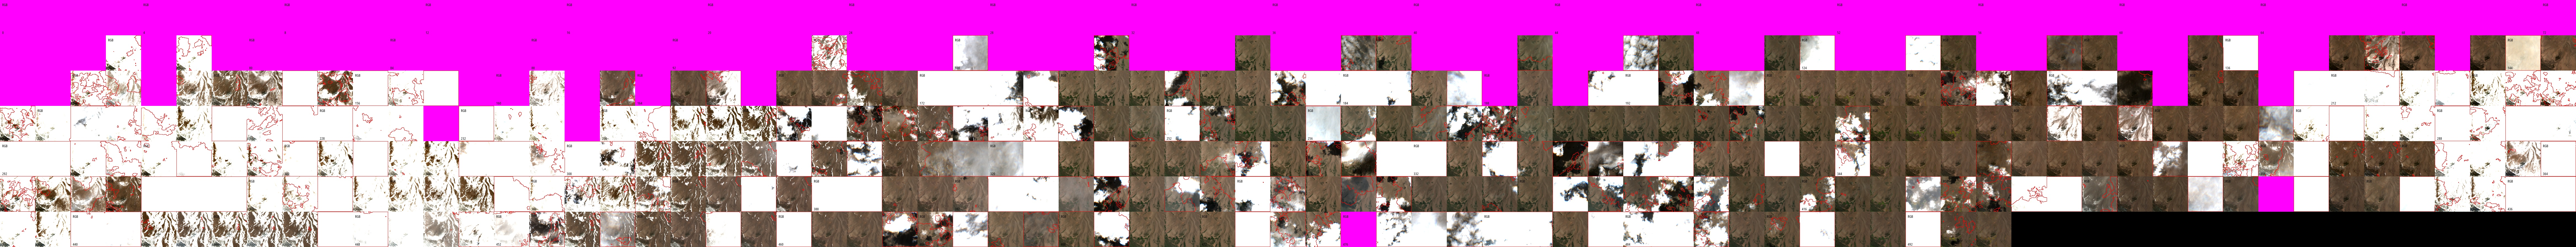

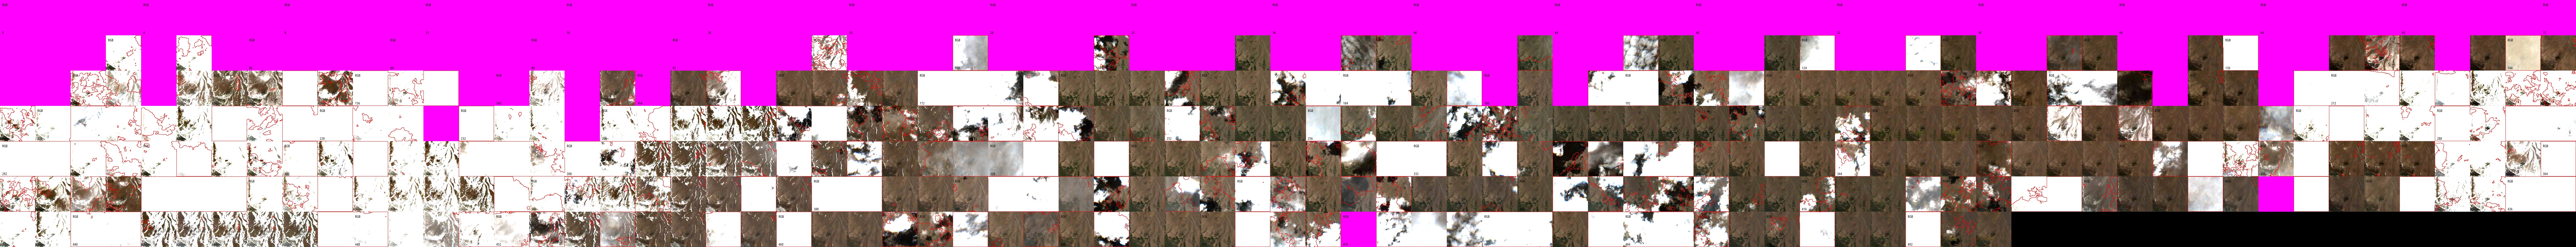

In [56]:
from IPython.display import display, Image
for image in Path('./').glob('*.jpg'):
    display(HTML(f'<h3>{image}</h3>'))
    display(Image(image))

Watch as a video (some formats might not be supported)

In [52]:
from IPython.display import Video, display, HTML, Image
for video in conversion_rules.keys():
    display(HTML(f'<h3>{video}</h3>'))
    display(Video(Path(output_path) / array_id / f'{video}.mkv', width=512, height=512))